In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import transformers

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

transformers.logging.set_verbosity_error()

In [4]:
df_topics = pd.read_csv('data/topics.csv')
df_opinions = pd.read_csv('data/opinions.csv')

In [3]:
max_length = 256  # Maximum length of input sentence to the model.
batch_size = 32
epochs = 2
labels_similarity = ['Effective', 'Adequate', 'Ineffective']
labels_type = ['Claim','Evidence','Counterclaim','Rebuttal']

In [4]:
df_opinions["label_effectiveness"] = df_opinions["effectiveness"].apply(
    lambda x: 0 if x == "Effective" else 1 if x == "Adequate" else 2
)
df_opinions["label_type"] = df_opinions["type"].apply(
    lambda x: 0 if x == "Claim" else 1 if x == "Evidence" else 2 if x == 'Counterclaim' else 3
)


In [5]:
df = pd.merge(df_topics[['topic_id','text']],df_opinions[['topic_id','text','label_type','label_effectiveness']],on='topic_id')
df.rename({'text_x':'topic','text_y':'opinions'},axis='columns',inplace=True)
df

,topic_id,topic,opinions,label_type,label_effectiveness
0,007ACE74B050,"On my perspective, I think that the face is a ...",I think that the face is a natural landform be...,0,1
1,007ACE74B050,"On my perspective, I think that the face is a ...","If life was on Mars, we would know by now. The...",1,1
2,007ACE74B050,"On my perspective, I think that the face is a ...",People thought that the face was formed by ali...,2,1
3,007ACE74B050,"On my perspective, I think that the face is a ...","though some say that life on Mars does exist, ...",3,2
4,007ACE74B050,"On my perspective, I think that the face is a ...","It says in paragraph 7, on April 5, 1998, Mars...",1,1
...,...,...,...,...,...
26872,FF9E0379CD98,"I think is not benefit for student, that take ...",you cant work or cant study after school with ...,1,1
26873,FF9E0379CD98,"I think is not benefit for student, that take ...",in the end you cant take the class because is ...,2,1
26874,FFA381E58FC6,Advice is something that can impact a persons ...,For many people they don't like only asking on...,0,1
26875,FFA381E58FC6,Advice is something that can impact a persons ...,also people have different views and opinions ...,0,1


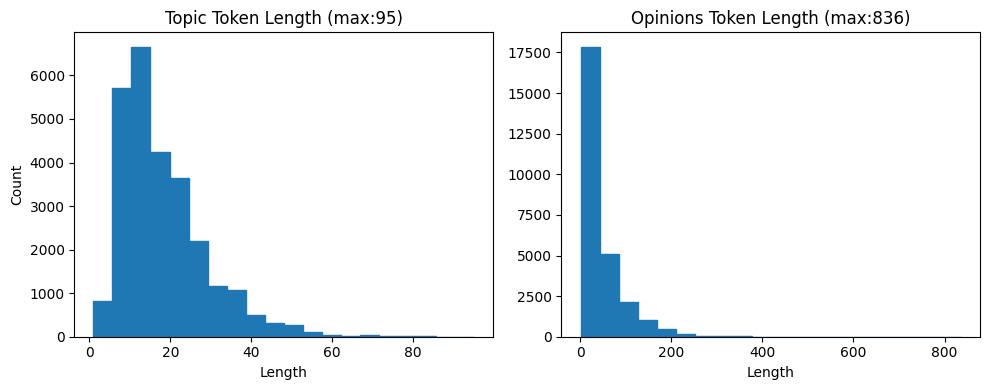

In [6]:
len_topic_token = df['topic'].apply(lambda x: len(x.split()))
len_opinions_token = df['opinions'].apply(lambda x: len(x.split()))

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(len_topic_token, bins = 20, color = 'C0', edgecolor = 'C0')
axes[0].set_title(f"Topic Token Length (max:{max(len_topic_token)})")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")

axes[1].hist(len_opinions_token, bins = 20, color = 'C0', edgecolor = 'C0' )
axes[1].set_title(f"Opinions Token Length (max:{max(len_opinions_token)})")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

In [7]:
df['token_count'] = df['opinions'].apply(lambda x: len(x.split()))  # Token sayısını al

# 256'dan fazla token içeren satırları filtrele
df = df[df['token_count'] <= 256]
# token_count sütununu artık kullanmadığımız için kaldırabiliriz
df = df.drop(columns=['token_count'])
df.reset_index(drop=True)
df

,topic_id,topic,opinions,label_type,label_effectiveness
0,007ACE74B050,"On my perspective, I think that the face is a ...",I think that the face is a natural landform be...,0,1
1,007ACE74B050,"On my perspective, I think that the face is a ...","If life was on Mars, we would know by now. The...",1,1
2,007ACE74B050,"On my perspective, I think that the face is a ...",People thought that the face was formed by ali...,2,1
3,007ACE74B050,"On my perspective, I think that the face is a ...","though some say that life on Mars does exist, ...",3,2
4,007ACE74B050,"On my perspective, I think that the face is a ...","It says in paragraph 7, on April 5, 1998, Mars...",1,1
...,...,...,...,...,...
26872,FF9E0379CD98,"I think is not benefit for student, that take ...",you cant work or cant study after school with ...,1,1
26873,FF9E0379CD98,"I think is not benefit for student, that take ...",in the end you cant take the class because is ...,2,1
26874,FFA381E58FC6,Advice is something that can impact a persons ...,For many people they don't like only asking on...,0,1
26875,FFA381E58FC6,Advice is something that can impact a persons ...,also people have different views and opinions ...,0,1


In [8]:
df_type = df[['topic','opinions','label_type']]
y_type = tf.keras.utils.to_categorical(df_type.label_type, num_classes=4)

df_effectiveness = df[['topic','opinions','label_effectiveness']]
y_effectiveness = tf.keras.utils.to_categorical(df_effectiveness.label_effectiveness, num_classes=3)

"""
df_claim = (df[df.type == "Claim"][['topic','opinions','label']].reset_index(drop=True))
y_claim = tf.keras.utils.to_categorical(df_claim.label, num_classes=3)

df_evidence = (df[df.type == "Evidence"][['topic','opinions','label']].reset_index(drop=True))
y_evidence = tf.keras.utils.to_categorical(df_evidence.label, num_classes=3)

df_counterclaim = (df[df.type == "Counterclaim"][['topic','opinions','label']].reset_index(drop=True))
y_counterclaim = tf.keras.utils.to_categorical(df_counterclaim.label, num_classes=3)

df_rebuttal = (df[df.type == "Rebuttal"][['topic','opinions','label']].reset_index(drop=True))
y_rebuttal = tf.keras.utils.to_categorical(df_rebuttal.label, num_classes=3)

dfs = [df_claim,df_evidence,df_counterclaim,df_rebuttal]
ys = [y_claim,y_evidence,y_counterclaim,y_rebuttal]
"""

""""""

''

In [9]:
class BertSemanticDataGenerator(tf.keras.utils.Sequence):

    def __init__(
        self,
        sentence_pairs,
        labels,
        batch_size=batch_size,
        shuffle=True,
        include_targets=True,
    ):
        self.sentence_pairs = sentence_pairs
        self.labels = labels
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.include_targets = include_targets
        # Load our BERT Tokenizer to encode the text.
        # We will use base-base-uncased pretrained model.
        self.tokenizer = transformers.BertTokenizer.from_pretrained(
            "bert-base-uncased", do_lower_case=True
        )
        self.indexes = np.arange(len(self.sentence_pairs))
        self.on_epoch_end()

    def __len__(self):
        # Denotes the number of batches per epoch.
        return len(self.sentence_pairs) // self.batch_size

    def __getitem__(self, idx):
        # Retrieves the batch of index.
        indexes = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        sentence_pairs = self.sentence_pairs[indexes]

        # With BERT tokenizer's batch_encode_plus batch of both the sentences are
        # encoded together and separated by [SEP] token.
        encoded = self.tokenizer.batch_encode_plus(
            sentence_pairs.tolist(),
            add_special_tokens=True,
            max_length=max_length,
            return_attention_mask=True,
            return_token_type_ids=True,
            pad_to_max_length=True,
            truncation=True,
            return_tensors="tf",
        )

        # Convert batch of encoded features to numpy array.
        input_ids = np.array(encoded["input_ids"], dtype="int32")
        attention_masks = np.array(encoded["attention_mask"], dtype="int32")
        token_type_ids = np.array(encoded["token_type_ids"], dtype="int32")

        # Set to true if data generator is used for training/validation.
        if self.include_targets:
            labels = np.array(self.labels[indexes], dtype="int32")
            return [input_ids, attention_masks, token_type_ids], labels
        else:
            return [input_ids, attention_masks, token_type_ids]

    def on_epoch_end(self):
        # Shuffle indexes after each epoch if shuffle is set to True.
        if self.shuffle:
            np.random.RandomState(42).shuffle(self.indexes)


In [10]:
def set_model(len_class:int,X:np.ndarray,y:np.ndarray):
  # Create the model under a distribution strategy scope.
  strategy = tf.distribute.MirroredStrategy()

  with strategy.scope():
      # Encoded token ids from BERT tokenizer.
      input_ids = tf.keras.layers.Input(
          shape=(max_length,), dtype=tf.int32, name="input_ids"
      )
      # Attention masks indicates to the model which tokens should be attended to.
      attention_masks = tf.keras.layers.Input(
          shape=(max_length,), dtype=tf.int32, name="attention_masks"
      )
      # Token type ids are binary masks identifying different sequences in the model.
      token_type_ids = tf.keras.layers.Input(
          shape=(max_length,), dtype=tf.int32, name="token_type_ids"
      )
      # Loading pretrained BERT model.
      bert_model = transformers.TFBertModel.from_pretrained("bert-base-uncased")
      # Freeze the BERT model to reuse the pretrained features without modifying them.
      bert_model.trainable = False

      bert_output = bert_model.bert(
          input_ids, attention_mask=attention_masks, token_type_ids=token_type_ids
      )
      sequence_output = bert_output.last_hidden_state
      pooled_output = bert_output.pooler_output
      # Add trainable layers on top of frozen layers to adapt the pretrained features on the new data.
      bi_lstm = tf.keras.layers.Bidirectional(
          tf.keras.layers.LSTM(64, return_sequences=True)
      )(sequence_output)
      # Applying hybrid pooling approach to bi_lstm sequence output.
      avg_pool = tf.keras.layers.GlobalAveragePooling1D()(bi_lstm)
      max_pool = tf.keras.layers.GlobalMaxPooling1D()(bi_lstm)
      concat = tf.keras.layers.concatenate([avg_pool, max_pool])
      dropout = tf.keras.layers.Dropout(0.3)(concat)
      output = tf.keras.layers.Dense(len_class, activation="softmax")(dropout)
      model = tf.keras.models.Model(
          inputs=[input_ids, attention_masks, token_type_ids], outputs=output
      )

      model.compile(
          optimizer=tf.keras.optimizers.Adam(),
          loss="categorical_crossentropy",
          metrics=["acc"],
      )


  print(f"Strategy: {strategy}")
  model.summary()

  print('\n\nFitting the model . . .')
  train_data = BertSemanticDataGenerator(
    X,
    y,
    batch_size=batch_size,
    shuffle=True,
  )

  history = model.fit(
      train_data,
      epochs=epochs,
      use_multiprocessing=True,
      workers=-1,
  )


  bert_model.trainable = True
  model.compile(
      optimizer=tf.keras.optimizers.Adam(1e-5),
      loss="categorical_crossentropy",
      metrics=["accuracy"],
  )
  model.summary()
  print('\n\nFine tuning the model . . .')
  history = model.fit(
      train_data,
      epochs=epochs,
      use_multiprocessing=True,
      workers=-1,
  )

  return model

In [18]:
model_effectiveness = set_model(len(labels_similarity),
                                df_effectiveness[["topic", "opinions"]].values.astype("str"),
                                y_effectiveness)

Strategy: <tensorflow.python.distribute.mirrored_strategy.MirroredStrategy object at 0x7a2e66a01cc0>
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 256)]                0         []                            
                                                                                                  
 attention_masks (InputLaye  [(None, 256)]                0         []                            
 r)                                                                                               
                                                                                                  
 token_type_ids (InputLayer  [(None, 256)]                0         []                            
 )                                                                                        

835/835 [==============================] - 1458s 2s/step - loss: 0.6931 - accuracy: 0.6889
Epoch 2/2
835/835 [==============================] - 1404s 2s/step - loss: 0.6028 - accuracy: 0.7339


In [12]:
model_type = set_model(len(labels_type),
                                df_type[["topic", "opinions"]].values.astype("str"),
                                y_type)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Strategy: <tensorflow.python.distribute.mirrored_strategy.MirroredStrategy object at 0x7a2ecf472920>
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 256)]                0         []                            
                                                                                                  
 attention_masks (InputLaye  [(None, 256)]                0         []                            
 r)                                                                                               
                                                                                                  
 token_type_ids (InputLayer  [(None, 256)]                0         []                            
 )                                                                                          

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Epoch 1/2
835/835 [==============================] - 552s 636ms/step - loss: 0.6510 - acc: 0.7592
Epoch 2/2
835/835 [==============================] - 535s 641ms/step - loss: 0.5360 - acc: 0.8029
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 256)]                0         []                            
                                                                                                  
 attention_masks (InputLaye  [(None, 256)]                0         []                            
 r)                                                                                               
                                                                                                  
 token_type_ids (InputLayer  [(None, 256)]                0         []                          

835/835 [==============================] - 1457s 2s/step - loss: 0.4877 - accuracy: 0.8213
Epoch 2/2
835/835 [==============================] - 1404s 2s/step - loss: 0.4190 - accuracy: 0.8464


In [ ]:
#df_claim_train, df_claim_test, y_claim_train, y_claim_test = train_test_split(df_claim,y_claim, test_size=0.2, random_state=42)

test_data = BertSemanticDataGenerator(
    df_effectiveness[["topic", "opinions"]].values.astype("str"),
    y_effectiveness,
    batch_size=batch_size,
    shuffle=False,
)
model_effectiveness.evaluate(test_data, verbose=1)

In [ ]:
def check(sentence1, sentence2, model, label_list):
    sentence_pairs = np.array([[str(sentence1), str(sentence2)]])
    test_data = BertSemanticDataGenerator(
        sentence_pairs, labels=None, batch_size=1, shuffle=False, include_targets=False,
    )

    proba = model.predict(test_data[0])[0]
    idx = np.argmax(proba)
    print(idx)
    proba = f"{proba[idx]: .2f}%"
    pred = label_list[idx]
    return pred, proba

In [ ]:
sentence1 = "Two women are observing something together."
sentence2 = "Two women are standing with their eyes closed."
check(sentence1, sentence2, model_effectiveness, labels_similarity)

1/1 [==============================] - 0s 191ms/step
1


('Adequate', ' 0.66%')

In [13]:
test_data = BertSemanticDataGenerator(
    df_type[["topic", "opinions"]].values.astype("str"),
    y_type,
    batch_size=batch_size,
    shuffle=False,
)
model_type.evaluate(test_data, verbose=1)

835/835 [==============================] - 491s 582ms/step - loss: 0.3141 - accuracy: 0.8918


[0.3140578269958496, 0.8918039202690125]

In [34]:
sentence1 = "Two women are observing something together."
sentence2 = "Two women are standing with their eyes closed."
check(sentence1, sentence2,model_type, labels_type)

1/1 [==============================] - 2s 2s/step
0


('Claim', ' 0.97%')

In [16]:
"""
import shutil

model_type.save("model/BertBasedType")
model_effectiveness.save("model/BertBasedEffectiveness")
shutil.make_archive("model/BertBasedType", 'zip', "model/BertBasedType")
shutil.make_archive("model/BertBasedEffectiveness", 'zip', "model/BertBasedEffectiveness")

classifier_type_model = keras.models.load_model("model/BertBasedType")
classifier_effectiveness_model = keras.models.load_model("model/BertBasedEffectiveness")
"""

In [26]:
from huggingface_hub import notebook_login
notebook_login()
#use token of huggingface_hub for login

In [28]:
from huggingface_hub import push_to_hub_keras

push_to_hub_keras(model_type,
    "Bert_Based_type_classifier_V2",
)

variables.data-00000-of-00001:   0%|          | 0.00/440M [00:00<?, ?B/s]

fingerprint.pb:   0%|          | 0.00/55.0 [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

keras_metadata.pb:   0%|          | 0.00/190k [00:00<?, ?B/s]

saved_model.pb:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/necover/Bert_Based_type_classifier_V2/commit/f2d1a09c1f7179fcf8418b93eb5fe8a3947477cd', commit_message='Push Keras model using huggingface_hub.', commit_description='', oid='f2d1a09c1f7179fcf8418b93eb5fe8a3947477cd', pr_url=None, pr_revision=None, pr_num=None)

In [29]:
push_to_hub_keras(model_effectiveness,
    "Bert_Based_effectiveness_classifier_V2",
)

fingerprint.pb:   0%|          | 0.00/55.0 [00:00<?, ?B/s]

saved_model.pb:   0%|          | 0.00/6.58M [00:00<?, ?B/s]

keras_metadata.pb:   0%|          | 0.00/190k [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

variables.data-00000-of-00001:   0%|          | 0.00/440M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/necover/Bert_Based_effectiveness_classifier_V2/commit/05b32fbc6fd5ca4601063aca15a6d75dbe517d91', commit_message='Push Keras model using huggingface_hub.', commit_description='', oid='05b32fbc6fd5ca4601063aca15a6d75dbe517d91', pr_url=None, pr_revision=None, pr_num=None)

In [30]:
loaded_model = from_pretrained_keras("necover/Bert_Based_effectiveness_classifier_V2")

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

.gitattributes:   0%|          | 0.00/1.59k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/840 [00:00<?, ?B/s]

history.json:   0%|          | 0.00/133 [00:00<?, ?B/s]

variables/variables.index:   0%|          | 0.00/12.2k [00:00<?, ?B/s]

fingerprint.pb:   0%|          | 0.00/55.0 [00:00<?, ?B/s]

model.png:   0%|          | 0.00/37.2k [00:00<?, ?B/s]

keras_metadata.pb:   0%|          | 0.00/190k [00:00<?, ?B/s]

variables.data-00000-of-00001:   0%|          | 0.00/440M [00:00<?, ?B/s]

saved_model.pb:   0%|          | 0.00/6.58M [00:00<?, ?B/s]